In [3]:
import pandas as pd
import json
import os
import ast
import numpy as np
import bz2
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# creating relative path for data files folder
datafiles = os.path.join("datafiles")

# getting events data path
events_path = os.path.join(datafiles, "events.json")


In [5]:
# reading in event data
events = pd.read_json(events_path, lines = True)

In [6]:
# converting data to a data frame form
events2 = pd.DataFrame(events)
event_rows = events2.iloc[0].tolist()

# Convert the list of dictionaries into a DataFrame
event_df = pd.DataFrame(event_rows)

pd.set_option("display.max_columns", None)
event_df.head()


,gameId,game_event_id,earlyDistribution,pressurePlayer,endTime,heightType,gameEventType,videoMissing,playerOffType,gameClock,duration,playerOn,pressureType,initialTouchType,endType,bodyType,touches,playerOff,subType,updatedAt,startTime,videoUrl,scoreValue,advantageType,team,outType,setpieceType,possessionEvents,player,touchesInBox,insertedAt,formattedGameClock,otherPlayer,videoAngleType,video
0,3812,6497466,None,None,141.008,G,FIRSTKICKOFF,False,None,0.0,0.000,None,None,None,None,L,1.0,None,S,2022-11-21T19:00:42,141.008,epitome.pff.com/87f7e9ab-da77-4fab-affd-173bbe...,None,None,"{'id': '366', 'name': 'Netherlands'}",None,K,"[{'ballCarryEvent': None, 'challengeEvent': No...","{'id': '3315', 'nickname': 'Vincent Janssen'}",NaN,2022-11-21T18:37:47,00:00,None,None,None
1,3812,6497474,None,None,144.645,G,OTB,False,None,1.0,2.570,None,None,None,None,R,3.0,None,S,2022-11-21T19:00:42,142.075,epitome.pff.com/87f7e9ab-da77-4fab-affd-173bbe...,None,None,"{'id': '366', 'name': 'Netherlands'}",None,None,"[{'ballCarryEvent': None, 'challengeEvent': No...","{'id': '1522', 'nickname': 'Frenkie de Jong'}",NaN,2022-11-21T18:38:06,00:01,None,None,None
2,3812,6497478,None,None,147.781,G,OTB,False,None,5.0,0.901,None,None,None,None,L,2.0,None,S,2022-11-21T19:00:42,146.880,epitome.pff.com/87f7e9ab-da77-4fab-affd-173bbe...,None,None,"{'id': '366', 'name': 'Netherlands'}",None,None,"[{'ballCarryEvent': None, 'challengeEvent': No...","{'id': '8026', 'nickname': 'Daley Blind'}",NaN,2022-11-21T18:38:18,00:05,None,None,None
3,3812,6497488,None,"{'id': '3858', 'nickname': 'Idrissa Gueye'}",149.082,G,OTB,False,None,8.0,0.000,None,P,None,None,R,1.0,None,S,2022-11-21T19:01:13,149.082,epitome.pff.com/87f7e9ab-da77-4fab-affd-173bbe...,None,None,"{'id': '366', 'name': 'Netherlands'}",None,None,"[{'ballCarryEvent': None, 'challengeEvent': No...","{'id': '1522', 'nickname': 'Frenkie de Jong'}",NaN,2022-11-21T18:38:33,00:08,None,None,None
4,3812,6497491,None,None,152.653,G,OTB,False,None,9.0,2.336,None,None,None,None,R,3.0,None,S,2022-11-21T19:00:42,150.317,epitome.pff.com/87f7e9ab-da77-4fab-affd-173bbe...,None,None,"{'id': '366', 'name': 'Netherlands'}",None,None,"[{'ballCarryEvent': None, 'challengeEvent': No...","{'id': '284', 'nickname': 'Nathan Aké'}",NaN,2022-11-21T18:38:44,00:09,None,None,None


In [7]:
# expanding variables with JSON 

# pressure_player variable
pressure_player = pd.json_normalize(event_df['pressurePlayer'])
pressure_player = pressure_player.add_prefix("pp_")

# playerOn variable
player_on = pd.json_normalize(event_df['playerOn'])
player_on = player_on.add_prefix("pon_")

# playerOff variable
player_off = pd.json_normalize(event_df['playerOff'])
player_off = player_off.add_prefix("poff_")

# team variable
team = pd.json_normalize(event_df['team'])
team = team.add_prefix("tm_")

# player variable
player = pd.json_normalize(event_df['player'])
player = player.add_prefix("player_")

# possession_events variable
possession_events = pd.json_normalize(event_df['possessionEvents'])
possession_events = possession_events.add_prefix("posev_")

# expanding possession_events further
pos0_df = pd.json_normalize(possession_events['posev_0'])
pos0_df = pos0_df.add_prefix("posev_")


# columns to remove from possession events data
bad_columns = ['pressurePlayer','playerOn','playerOff','team','player','possessionEvents']
# replacing them with new ones
event_df = event_df.drop(columns=bad_columns).join([pressure_player,player_on,player_off,team,player,pos0_df])

grades = pd.json_normalize(event_df['posev_grades'])
grades_0 = pd.json_normalize(grades[grades.columns[0]])
grades_0 = grades_0.add_prefix("gr0_")

event_df = event_df.drop(columns=['posev_grades']).join([grades_0])
                

In [8]:
# columns to keep track of
good_columns = ['gameId','game_event_id','gameEventType','pressureType','touches','pp_id','tm_id','tm_name','player_id','posev_id',
                'posev_possessionEventType','posev_passingEvent.passOutcomeType','posev_passingEvent.createsSpace',
                'posev_passingEvent.opportunityType','posev_passingEvent.targetPlayer.id','gr0_gradeLabel',
                'gr0_playerGrade']

# only keeping relevant variables
event_df = event_df[good_columns]

na_cols = ['posev_passingEvent.createsSpace','posev_passingEvent.opportunityType','gr0_gradeLabel','gr0_playerGrade']
event_df[na_cols] = event_df[na_cols].fillna(0)

event_df.head()

,gameId,game_event_id,gameEventType,pressureType,touches,pp_id,tm_id,tm_name,player_id,posev_id,posev_possessionEventType,posev_passingEvent.passOutcomeType,posev_passingEvent.createsSpace,posev_passingEvent.opportunityType,posev_passingEvent.targetPlayer.id,gr0_gradeLabel,gr0_playerGrade
0,3812,6497466,FIRSTKICKOFF,None,1.0,NaN,366,Netherlands,3315,6373793,PA,C,0,0,1522,Passer,0.0
1,3812,6497474,OTB,None,3.0,NaN,366,Netherlands,1522,6373803,PA,C,0,0,8026,0,0.0
2,3812,6497478,OTB,None,2.0,NaN,366,Netherlands,8026,6373808,PA,C,0,0,1522,0,0.0
3,3812,6497488,OTB,P,1.0,3858,366,Netherlands,1522,6373814,PA,C,0,0,284,0,0.0
4,3812,6497491,OTB,None,3.0,NaN,366,Netherlands,284,6373818,PA,C,0,0,37,0,0.0


In [9]:
# getting metadata path
meta_path = os.path.join(datafiles, "metadata.csv")

# read in metadata to get home / away team ids
metadata = pd.read_csv(meta_path)

type(metadata['awayTeam'].iloc[0])

# getting data into right form to expand nested dictionaries
metadata['awayTeam'] = metadata['awayTeam'].apply(ast.literal_eval)
metadata['homeTeam'] = metadata['homeTeam'].apply(ast.literal_eval)

# Expand nested dictionaries in 'awayTeam' and 'homeTeam'
awaytm = pd.json_normalize(metadata['awayTeam']).add_prefix('away_')
hometm = pd.json_normalize(metadata['homeTeam']).add_prefix('home_')

# getting metadata into an unnested form
metadata2 = pd.concat([metadata.drop(['awayTeam', 'homeTeam'], axis=1), awaytm, hometm], axis=1)

# taking out unnecessary columns
good_cols = ['away_id','away_name','home_id','home_name','id']
metadata2 = metadata2[good_cols]

# changing column game to gameId to join with other data
metadata2.rename(columns={'id':'gameId'},inplace=True)
metadata2.head()

,away_id,away_name,home_id,home_name,gameId
0,366,Netherlands,372,Senegal,3812
1,384,Wales,51,United States,3815
2,378,Tunisia,367,Denmark,3817
3,57,Japan,368,Germany,3821
4,369,Uruguay,365,Portugal,3843


In [10]:
# join event_df with metadata to get the home and away teams for each game
event_meta = pd.merge(event_df,metadata2,on='gameId')

# creating a new variable status that says whether event was by home or away team player
event_meta['status'] = np.where(event_meta['tm_id'] == event_meta['home_id'], 'home',
                       np.where(event_meta['tm_id'] == event_meta['away_id'], 'away', ''))

event_meta.head()

event_meta['pressureType'] = event_meta['pressureType'].apply(lambda x: 1 if x in ['L','P'] else 0)

# Create mapping for opportunity column
opp_map = {
    'C': 10,
    'D': 5,
    'H': 2,
    'N': -1,
    'P': -5
}

# Apply mapping to opportunities
event_meta['posev_passingEvent.opportunityType'] = event_meta['posev_passingEvent.opportunityType'].map(opp_map).fillna(0)

# has rows that represent play-by-play data
event_meta.head()
    

,gameId,game_event_id,gameEventType,pressureType,touches,pp_id,tm_id,tm_name,player_id,posev_id,posev_possessionEventType,posev_passingEvent.passOutcomeType,posev_passingEvent.createsSpace,posev_passingEvent.opportunityType,posev_passingEvent.targetPlayer.id,gr0_gradeLabel,gr0_playerGrade,away_id,away_name,home_id,home_name,status
0,3812,6497466,FIRSTKICKOFF,0,1.0,NaN,366,Netherlands,3315,6373793,PA,C,0,0.0,1522,Passer,0.0,366,Netherlands,372,Senegal,away
1,3812,6497474,OTB,0,3.0,NaN,366,Netherlands,1522,6373803,PA,C,0,0.0,8026,0,0.0,366,Netherlands,372,Senegal,away
2,3812,6497478,OTB,0,2.0,NaN,366,Netherlands,8026,6373808,PA,C,0,0.0,1522,0,0.0,366,Netherlands,372,Senegal,away
3,3812,6497488,OTB,1,1.0,3858,366,Netherlands,1522,6373814,PA,C,0,0.0,284,0,0.0,366,Netherlands,372,Senegal,away
4,3812,6497491,OTB,0,3.0,NaN,366,Netherlands,284,6373818,PA,C,0,0.0,37,0,0.0,366,Netherlands,372,Senegal,away


In [11]:
# events to count per game: 
# possession events - ball carry (BC), challenge (CH), clearance (CL), cross (CR), pass (PA), rebound (RE), shot (SH) by team *******
# total pressures (by pressure type) - 1 if either L or P, 0 else *******
# creates space - sum this to get total per game by team *******
# pass_outcome_type - C is complete (binary 1), B D G I O S are incomplete (binary 0) *******
# opportunity_type - C: 10, D: 5, H: 2, N: -1, P: -5 (add these up for each team's game) *******
# gr0_player grade: average these over passes specifically **********

# aggregate event data
event_res1 = event_meta.groupby(['gameId','status','tm_id','tm_name']).agg(
    ball_carries = ('posev_possessionEventType',lambda x: (x == 'BC').sum()),
    challenges = ('posev_possessionEventType',lambda x: (x == 'CH').sum()),
    clearances = ('posev_possessionEventType',lambda x: (x == 'CL').sum()),
    crosses = ('posev_possessionEventType',lambda x: (x == 'CR').sum()),
    pass_atts = ('posev_possessionEventType',lambda x: (x == 'PA').sum()),
    rebs = ('posev_possessionEventType',lambda x: (x == 'RE').sum()),
    shots = ('posev_possessionEventType',lambda x: (x == 'SH').sum()),
    pressures = ('pressureType','sum'),
    space_creation = ('posev_passingEvent.createsSpace','sum'),
    pass_completions = ('posev_passingEvent.passOutcomeType',lambda x: (x == 'C').sum()),
    touches = ('touches','sum')
).reset_index()

event_res2 = event_meta[event_meta['posev_possessionEventType'] == 'PA'].groupby(['gameId','status','tm_id','tm_name']).agg(
    avg_grade = ('gr0_playerGrade','mean')
).reset_index()


event_results = pd.merge(event_res1,event_res2,on=['gameId','status','tm_id','tm_name'])

# adding completion percentage as the response variable
event_results['comp_pct'] = event_results['pass_completions'] / event_results['pass_atts']

# gives us the game-by-game results for each team; will be used in conjunction with tracking data ************
event_results.head()

# next step: average game-by-game metrics of teams in the tournament BEFORE World Cup Final; remove WC Final #####################

bad_cols = ['gameId','status']
team_summaries = event_results[event_results['gameId'] != 10517].drop(columns=bad_cols).groupby(['tm_id','tm_name']).mean()

team_summaries.sort_values(by='comp_pct',ascending=False).head(10)


team_summaries.head()

# making sure team ids and team names are being considered as columns
team_summaries.reset_index(inplace=True)

qf_tms = ['Netherlands','Argentina','Croatia','Brazil','England','France','Morocco','Portugal']

qf = team_summaries[team_summaries['tm_name'].isin(qf_tms)]

qf.head()


,tm_id,tm_name,ball_carries,challenges,clearances,crosses,pass_atts,rebs,shots,pressures,space_creation,pass_completions,touches,avg_grade,comp_pct
1,361,Brazil,12.800000,66.200000,13.400000,20.800000,600.200000,21.000000,18.400000,144.4,8.8,535.400000,1706.400000,-0.003186,0.891652
3,363,France,12.000000,59.333333,18.333333,19.500000,522.000000,17.833333,13.166667,131.0,6.833333,455.500000,1438.166667,-0.009644,0.867101
4,364,Argentina,12.666667,62.500000,18.000000,15.166667,622.166667,18.666667,14.500000,151.0,9.333333,544.166667,1761.500000,-0.011691,0.867399
5,365,Portugal,14.000000,50.600000,13.800000,21.600000,590.200000,15.000000,12.800000,121.2,7.6,514.000000,1574.800000,-0.008892,0.869571
6,366,Netherlands,10.000000,60.200000,21.600000,15.200000,565.600000,20.800000,9.600000,142.8,5.0,482.000000,1456.800000,-0.006466,0.841890


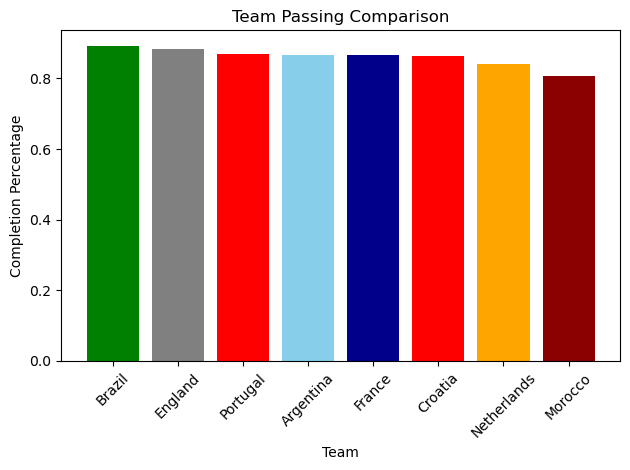

In [12]:
# visuals heading into the WC Final for quarterfinalists
qf_sort = qf.sort_values(by='comp_pct', ascending=False)
color_vec = ['green', 'gray', 'red', 'skyblue','darkblue','red','orange','darkred']
plt.bar(qf_sort['tm_name'],qf_sort['comp_pct'],color=color_vec)

plt.title('Team Passing Comparison')
plt.xlabel('Team')
plt.ylabel('Completion Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


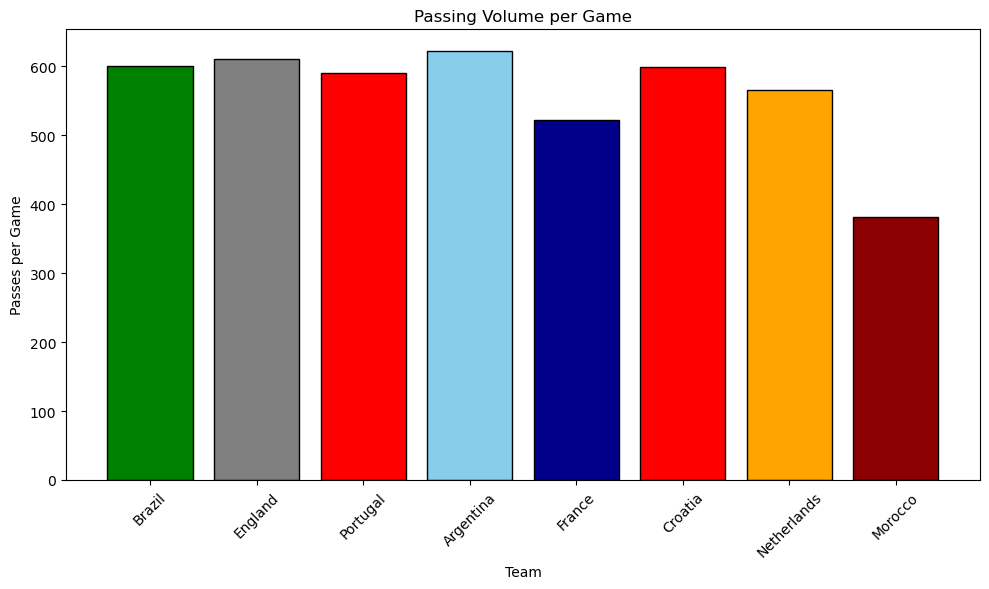

In [15]:
qf_sort = qf.sort_values(by='comp_pct', ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
color_vec = ['green', 'gray', 'red', 'skyblue','darkblue','red','orange','darkred']
# Stacked bar plot with attempts on the bottom
ax.bar(qf_sort['tm_name'], qf_sort['pass_atts'], label='Attempts', color=color_vec,edgecolor='black')

plt.title('Passing Volume per Game')
plt.xlabel('Team')
plt.ylabel('Passes per Game')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# load our first tracking data set for one game

# getting tracking data path
tracking_path = os.path.join(datafiles, '3816.jsonl.bz2')

na_cols = ['game_event_id','possession_event_id','game_event','possession_event']

with bz2.open(tracking_path,'rt') as f:
    track1 = pd.read_json(f, lines=True)
    track1 = track1.dropna(subset=na_cols)
    
track1.head()

,version,gameRefId,generatedTime,smoothedTime,videoTimeMs,frameNum,period,periodElapsedTime,periodGameClockTime,homePlayers,homePlayersSmoothed,awayPlayers,awayPlayersSmoothed,balls,ballsSmoothed,game_event_id,possession_event_id,game_event,possession_event
0,4.1.0,3816.0,2023-07-11T20:51:08.728935Z,2023-12-23T23:05:16.522202Z,101968.635,3056,1,0.000000,0.000000,"[{'jerseyNum': '19', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '19', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'visibility': 'VISIBLE', 'x': 0.99, 'y': 0.1...","{'visibility': 'VISIBLE', 'x': -0.63, 'y': -1....",6500893.0,6377587.0,"{'game_id': 3816, 'game_event_type': 'FIRSTKIC...","{'game_id': 3816, 'game_event_id': 6500893, 'p..."
71,None,NaN,None,None,104337.671,3127,1,2.368671,2.368671,"[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'visibility': 'VISIBLE', 'x': 8.71, 'y': -0....","{'visibility': 'VISIBLE', 'x': 10.53, 'y': -0....",6500923.0,6377614.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f...","{'game_id': 3816, 'game_event_id': 6500923, 'p..."
99,None,NaN,None,None,105271.939,3155,1,3.302939,3.302939,"[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'visibility': 'VISIBLE', 'x': 2.27, 'y': -1....","{'visibility': 'VISIBLE', 'x': -0.58, 'y': -0....",6500912.0,6377606.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f...","{'game_id': 3816, 'game_event_id': 6500912, 'p..."
182,None,NaN,None,None,108041.375,3238,1,6.072375,6.072375,"[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'visibility': 'ESTIMATED', 'x': 8.69, 'y': 8...","{'visibility': 'ESTIMATED', 'x': 9.86, 'y': 3....",6500928.0,6377619.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f...","{'game_id': 3816, 'game_event_id': 6500928, 'p..."
324,None,NaN,None,None,112779.446,3380,1,10.810446,10.810446,"[{'jerseyNum': '19', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '19', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","[{'visibility': 'ESTIMATED', 'x': 2.41, 'y': 2...","{'visibility': 'ESTIMATED', 'x': 6.28, 'y': 25...",6500933.0,6377625.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f...","{'game_id': 3816, 'game_event_id': 6500933, 'p..."


In [14]:
# analyzing one game of tracking data

keep_vars = ['gameRefId','homePlayersSmoothed','awayPlayersSmoothed','ballsSmoothed','game_event_id',
             'possession_event_id','game_event']


track1_new = track1[keep_vars]



track1_new = track1_new.copy()

# front filling gameIds to be consistent with rest of 
track1_new['gameRefId'] = track1_new['gameRefId'].ffill()

track1_new.head()


homeSmooth = pd.json_normalize(track1_new['homePlayersSmoothed']).add_prefix('homesmooth_').iloc[:, :11]
awaySmooth = pd.json_normalize(track1_new['awayPlayersSmoothed']).add_prefix('awaysmooth_').iloc[:, :11]
ballSmooth = pd.json_normalize(track1_new['ballsSmoothed']).add_prefix('ballsmooth_').iloc[:, 1:3]
gm_evnt = pd.json_normalize(track1_new['game_event']).add_prefix('gmevt_')


homeSmooth0 = pd.json_normalize(homeSmooth['homesmooth_0']).add_prefix('homesmooth0_')

track1_new.head()


,gameRefId,homePlayersSmoothed,awayPlayersSmoothed,ballsSmoothed,game_event_id,possession_event_id,game_event
0,3816.0,"[{'jerseyNum': '19', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","{'visibility': 'VISIBLE', 'x': -0.63, 'y': -1....",6500893.0,6377587.0,"{'game_id': 3816, 'game_event_type': 'FIRSTKIC..."
71,3816.0,"[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","{'visibility': 'VISIBLE', 'x': 10.53, 'y': -0....",6500923.0,6377614.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f..."
99,3816.0,"[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","{'visibility': 'VISIBLE', 'x': -0.58, 'y': -0....",6500912.0,6377606.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f..."
182,3816.0,"[{'jerseyNum': '19', 'confidence': 'LOW', 'vis...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","{'visibility': 'ESTIMATED', 'x': 9.86, 'y': 3....",6500928.0,6377619.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f..."
324,3816.0,"[{'jerseyNum': '19', 'confidence': 'HIGH', 'vi...","[{'jerseyNum': '21', 'confidence': 'LOW', 'vis...","{'visibility': 'ESTIMATED', 'x': 6.28, 'y': 25...",6500933.0,6377625.0,"{'game_id': 3816, 'game_event_type': 'OTB', 'f..."


In [15]:
# First step: forming a loop to capture home player coordinates ################################################
# List to store the transformed DataFrames
homeSmooth_combined = []

# Loop through columns 0 to 10
for i in range(11):
    normalized_df = pd.json_normalize(homeSmooth[f'homesmooth_{i}']).add_prefix(f'homesmooth{i}_')
     # Drop the unwanted columns
    normalized_df = normalized_df.drop(columns=[f'homesmooth{i}_confidence', f'homesmooth{i}_visibility'], errors='ignore')
    homeSmooth_combined.append(normalized_df)

# Combine all transformed DataFrames into one row
home_full = pd.concat(homeSmooth_combined, axis=1)


# Next step: forming a loop to capture away player coordinates ################################################
# List to store the transformed DataFrames
awaySmooth_combined = []

# Loop through columns 0 to 10
for i in range(11):
    normalized_df = pd.json_normalize(awaySmooth[f'awaysmooth_{i}']).add_prefix(f'awaysmooth{i}_')
     # Drop the unwanted columns
    normalized_df = normalized_df.drop(columns=[f'awaysmooth{i}_confidence', f'awaysmooth{i}_visibility'], errors='ignore')
    awaySmooth_combined.append(normalized_df)

# Combine all transformed DataFrames into one row
away_full = pd.concat(awaySmooth_combined, axis=1)


# combining home and away player coordinates
player_coords = pd.concat([home_full,away_full],axis=1)


# combining player and ball coordinates
all_coords = pd.concat([player_coords,ballSmooth],axis=1)


# final combination of coordinate and game event data
all_track3816 = pd.concat([all_coords,gm_evnt],axis=1)

all_track3816.head()

,homesmooth0_jerseyNum,homesmooth0_x,homesmooth0_y,homesmooth1_jerseyNum,homesmooth1_x,homesmooth1_y,homesmooth2_jerseyNum,homesmooth2_x,homesmooth2_y,homesmooth3_jerseyNum,homesmooth3_x,homesmooth3_y,homesmooth4_jerseyNum,homesmooth4_x,homesmooth4_y,homesmooth5_jerseyNum,homesmooth5_x,homesmooth5_y,homesmooth6_jerseyNum,homesmooth6_x,homesmooth6_y,homesmooth7_jerseyNum,homesmooth7_x,homesmooth7_y,homesmooth8_jerseyNum,homesmooth8_x,homesmooth8_y,homesmooth9_jerseyNum,homesmooth9_x,homesmooth9_y,homesmooth10_jerseyNum,homesmooth10_x,homesmooth10_y,awaysmooth0_jerseyNum,awaysmooth0_x,awaysmooth0_y,awaysmooth1_jerseyNum,awaysmooth1_x,awaysmooth1_y,awaysmooth2_jerseyNum,awaysmooth2_x,awaysmooth2_y,awaysmooth3_jerseyNum,awaysmooth3_x,awaysmooth3_y,awaysmooth4_jerseyNum,awaysmooth4_x,awaysmooth4_y,awaysmooth5_jerseyNum,awaysmooth5_x,awaysmooth5_y,awaysmooth6_jerseyNum,awaysmooth6_x,awaysmooth6_y,awaysmooth7_jerseyNum,awaysmooth7_x,awaysmooth7_y,awaysmooth8_jerseyNum,awaysmooth8_x,awaysmooth8_y,awaysmooth9_jerseyNum,awaysmooth9_x,awaysmooth9_y,awaysmooth10_jerseyNum,awaysmooth10_x,awaysmooth10_y,ballsmooth_x,ballsmooth_y,gmevt_game_id,gmevt_game_event_type,gmevt_formatted_game_clock,gmevt_player_id,gmevt_player_name,gmevt_shirt_number,gmevt_position_group_type,gmevt_team_id,gmevt_team_name,gmevt_start_time,gmevt_end_time,gmevt_duration,gmevt_inserted_at,gmevt_updated_at,gmevt_video_url,gmevt_home_team,gmevt_sequence,gmevt_home_ball,gmevt_start_frame,gmevt_end_frame
0,19,-18.988,-1.544,26,-14.490,-23.831,23,-38.079,-1.169,10,1.740,4.839,5,-10.241,-1.758,11,-2.572,-28.339,13,-7.010,-23.311,7,-9.334,-10.269,3,-18.566,17.855,22,-0.626,-11.556,17,-5.730,5.083,21,36.702,-1.830,13,10.364,-20.170,5,17.351,-11.883,12,0.804,33.227,17,22.278,4.827,10,-1.915,-24.167,7,2.894,8.110,23,11.148,-0.869,8,4.800,-9.696,9,-4.331,-12.099,11,-0.632,-1.706,-0.63,-1.71,3816,FIRSTKICKOFF,00:00,14011,Saleh Al-Shehri,11,CF,382,Saudi Arabia,101.969,101.969,0.000,2022-11-22T12:49:06,2022-11-22T14:57:42,epitome-staging.pff.com/en/film_room/d7ffb3e6-...,0.0,1,False,3056,3056
1,19,-18.431,0.646,26,-15.789,-22.112,23,-38.950,-1.049,10,1.867,5.422,5,-10.035,-0.381,11,-7.624,-22.565,13,-8.977,-25.515,7,-10.657,-9.733,3,-18.435,19.115,22,0.813,-8.714,17,-4.870,9.452,21,35.959,-1.643,13,8.371,-20.068,5,16.777,-10.715,12,-0.036,32.796,17,19.723,7.772,10,-8.652,-21.521,7,0.747,7.029,23,10.532,-0.052,8,2.561,-8.501,9,-10.918,-9.971,11,-0.860,-0.625,10.53,-0.05,3816,OTB,00:01,14003,Mohamed Kanno,23,CM,382,Saudi Arabia,103.103,104.338,1.235,2022-11-22T12:50:47,2022-11-22T14:57:42,epitome-staging.pff.com/en/film_room/d7ffb3e6-...,0.0,1,False,3090,3127
2,19,-18.174,1.522,26,-16.234,-21.353,23,-39.237,-0.914,10,1.982,5.580,5,-9.909,0.154,11,-9.389,-20.462,13,-9.841,-26.052,7,-10.957,-9.594,3,-18.278,19.538,22,1.253,-7.590,17,-4.634,11.185,21,35.599,-1.522,13,7.405,-20.044,5,16.675,-10.109,12,-0.491,32.520,17,18.614,8.977,10,-11.131,-20.837,7,-0.128,6.951,23,10.379,0.233,8,1.446,-8.221,9,-13.108,-9.248,11,-0.579,-0.141,-0.58,-0.14,3816,OTB,00:03,14011,Saleh Al-Shehri,11,CF,382,Saudi Arabia,105.272,105.272,0.000,2022-11-22T12:50:27,2022-11-22T14:57:42,epitome-staging.pff.com/en/film_room/d7ffb3e6-...,0.0,1,False,3155,3155
3,19,-18.058,5.834,26,-17.000,-17.113,23,-39.774,0.161,10,3.223,8.614,5,-8.312,5.927,11,-10.206,-16.648,13,-12.368,-16.781,7,-10.437,-5.277,3,-16.357,21.967,22,3.118,-2.543,17,-4.243,16.718,21,34.699,-0.382,13,4.099,-19.834,5,16.207,-7.443,12,-1.996,32.361,17,14.688,15.162,10,-14.465,-19.783,7,-3.201,12.366,23,9.863,3.810,8,0.263,-4.511,9,-15.907,-4.770,11,-4.080,2.968,9.86,3.81,3816,OTB,00:04,14003,Mohamed Kanno,23,CM,382,Saudi Arabia,106.139,108.041,1.902,2022-11-22T12:51:06,2022-11-22T14:57:42,epitome-staging.pff.com/en/film_room/d7ffb3e6-...,0.0,1,False,3181,3238
4,19,-22.905,15.480,26,-19.802,-8.543,23,-40.933,2.421,10,0.021,19.410,5,-8.112,19.318,11,-8.675,-13.200,13,-16.970,-1.923,7,-11.401,4.497,3,-16.768,27.192,22,6.459,8.263,17,-0.570,25.908,21,34.182,

In [16]:
# looking at all France or Argentina games, we see that WC Final was gameId 10517
fra_arg = metadata2[
(metadata2['home_name'].isin(['Argentina','France'])) |
(metadata2['away_name'].isin(['Argentina','France']))
]

# list of games we need to download
fraarg_new = fra_arg['gameId'].tolist()

fraarg_new

[3816,
 3819,
 3834,
 3835,
 3849,
 3850,
 10511,
 10517,
 10503,
 10504,
 10513,
 10514,
 10515]

In [17]:
# load and process the rest of the tracking files for France and Argentina games

# List of game IDs
fraarg_new

# Columns to check for NA values
na_cols = ['game_event_id', 'possession_event_id', 'game_event', 'possession_event']


# FUNCTION TO LOAD ALL TRACKING DATA
def process_game(gameId):
    # getting tracking data path
    tracking_path = os.path.join(datafiles, f'{gameId}.jsonl.bz2')
    
    with bz2.open(tracking_path,'rt') as f:
        track1 = pd.read_json(f, lines=True)
        track1 = track1.dropna(subset=na_cols)
    
    # analyzing one game of tracking data
    keep_vars = ['gameRefId','homePlayersSmoothed','awayPlayersSmoothed','ballsSmoothed','game_event_id',
                 'possession_event_id','game_event']
    
    track1_new = track1[keep_vars].copy()

    # front filling gameIds to be consistent with rest of game data
    track1_new['gameRefId'] = track1_new['gameRefId'].ffill()

    # expanding lists within the following elements of the data
    homeSmooth = pd.json_normalize(track1_new['homePlayersSmoothed']).add_prefix('homesmooth_').iloc[:, :11]
    awaySmooth = pd.json_normalize(track1_new['awayPlayersSmoothed']).add_prefix('awaysmooth_').iloc[:, :11]
    ballSmooth = pd.json_normalize(track1_new['ballsSmoothed']).add_prefix('ballsmooth_').iloc[:, 1:3]
    gm_evnt = pd.json_normalize(track1_new['game_event']).add_prefix('gmevt_')

    # First step: forming a loop to capture home player coordinates ################################################
    # List to store the transformed DataFrames
    homeSmooth_combined = []

    # Loop through columns 0 to 10
    for i in range(11):
        normalized_df = pd.json_normalize(homeSmooth[f'homesmooth_{i}']).add_prefix(f'homesmooth{i}_')
         # Drop the unwanted columns
        normalized_df = normalized_df.drop(columns=[f'homesmooth{i}_confidence', f'homesmooth{i}_visibility'], errors='ignore')
        homeSmooth_combined.append(normalized_df)
    # Combine all transformed DataFrames into one row
    home_full = pd.concat(homeSmooth_combined, axis=1)


    # Next step: forming a loop to capture away player coordinates ################################################
    # List to store the transformed DataFrames
    awaySmooth_combined = []

    # Loop through columns 0 to 10
    for i in range(11):
        normalized_df = pd.json_normalize(awaySmooth[f'awaysmooth_{i}']).add_prefix(f'awaysmooth{i}_')
         # Drop the unwanted columns
        normalized_df = normalized_df.drop(columns=[f'awaysmooth{i}_confidence', f'awaysmooth{i}_visibility'], errors='ignore')
        awaySmooth_combined.append(normalized_df)
    # Combine all transformed DataFrames into one row
    away_full = pd.concat(awaySmooth_combined, axis=1)


    # combining home and away player coordinates
    player_coords = pd.concat([home_full,away_full],axis=1)

    # combining player and ball coordinates
    all_coords = pd.concat([player_coords,ballSmooth],axis=1)

    # final combination of coordinate and game event data
    all_track = pd.concat([all_coords,gm_evnt],axis=1)

    return all_track

# going through all games with the above function
game_data_store = {}
for gameId in fraarg_new:
    print(f"Loading game {gameId}")
    game_data_store[f'all_track{gameId}'] = process_game(gameId)



Loading game 3816
Loading game 3819
Loading game 3834
Loading game 3835
Loading game 3849
Loading game 3850
Loading game 10511
Loading game 10517
Loading game 10503
Loading game 10504
Loading game 10513
Loading game 10514
Loading game 10515


In [18]:
import pandas as pd
from scipy.spatial.distance import euclidean
import numpy as np

def calculate_team_average_distances(game_df, metadata2):
    # Rename the game_id column to gameId in game_df
    game_df.rename(columns={'gmevt_game_id': 'gameId'}, inplace=True)
    
    # Merge with metadata2
    final_df = pd.merge(game_df, metadata2, on='gameId')
    
    # Function to calculate the average distance between players for a single frame
    def calculate_avg_player_distances(row, team_prefix, team_id_column, team_type):
        num_players = 11  # Assuming there are 11 players per team
        
        # Extract player coordinates
        player_coords = row[[f"{team_prefix}{i}_x" for i in range(num_players)] +
                            [f"{team_prefix}{i}_y" for i in range(num_players)]].values.reshape(num_players, 2)
        
        # Calculate all pairwise distances for the players in this frame
        pairwise_distances = [
            euclidean(player_coords[i], player_coords[j])
            for i in range(num_players)
            for j in range(i + 1, num_players)
        ]
        
        return np.mean(pairwise_distances), row[team_id_column], team_type
    
    # Apply the function to calculate frame-wise distances for home and away teams
    home_avg_distances, home_team_ids, _ = zip(*final_df.apply(calculate_avg_player_distances, axis=1, team_prefix='homesmooth', team_id_column='home_id', team_type='home'))
    away_avg_distances, away_team_ids, _ = zip(*final_df.apply(calculate_avg_player_distances, axis=1, team_prefix='awaysmooth', team_id_column='away_id', team_type='away'))
    
    # Create the result DataFrame
    result_df = pd.DataFrame({
        'gameId': game_df['gameId'],
        'home_avg_distance': home_avg_distances,
        'away_avg_distance': away_avg_distances
    })

    # Calculate the averages
    home_avg_distance_mean = result_df['home_avg_distance'].mean()
    away_avg_distance_mean = result_df['away_avg_distance'].mean()

    # Create a new DataFrame with the gameId and the calculated averages
    new_df1 = pd.DataFrame({
        'gameId': [result_df['gameId'].iloc[0]],
        'home_avg_distance': [home_avg_distance_mean],
        'away_avg_distance': [away_avg_distance_mean]
    })

    merged_df = pd.merge(new_df1, metadata2, on='gameId')

    # Create new rows for home and away distances
    fin_df = merged_df.melt(id_vars=['gameId', 'home_id', 'home_name', 'away_id', 'away_name'],
                            value_vars=['home_avg_distance', 'away_avg_distance'],
                            var_name='status', value_name='distance')

    # Map team_id and team_name based on the status
    fin_df['team_id'] = fin_df.apply(lambda x: x['home_id'] if x['status'] == 'home_avg_distance' else x['away_id'], axis=1)
    fin_df['team_name'] = fin_df.apply(lambda x: x['home_name'] if x['status'] == 'home_avg_distance' else x['away_name'], axis=1)

    # Select and rearrange the columns
    fin_df = fin_df[['gameId', 'distance', 'team_id', 'team_name']]

    return fin_df

# Example usage:
result_df = calculate_team_average_distances(all_track3816, metadata2)

print(result_df)


   gameId   distance team_id     team_name
0    3816  29.475957     364     Argentina
1    3816  30.850800     382  Saudi Arabia


In [18]:
# for tracking data, we want avg distance per team from midfield

def process_game_data(item_name, metadata2):
    game_df = game_data_store[item_name]
    return calculate_team_average_distances(game_df, metadata2)


tracking_results = []

for item_name in game_data_store.keys():
    result = process_game_data(item_name,metadata2)
    tracking_results.append(result)


tracking_results


NameError: name 'game_data_store' is not defined

In [17]:
# Create DataFrame
# Initialize an empty DataFrame

# combining elements of tracking_results; less elegant solution since pd.DataFrame was giving us errors for some reason
tracking_df = pd.concat([tracking_results[0], tracking_results[1], tracking_results[2],tracking_results[3],tracking_results[4],
                        tracking_results[5], tracking_results[6], tracking_results[7],tracking_results[8],tracking_results[9],
                        tracking_results[10], tracking_results[11], tracking_results[12]], ignore_index=True)

tracking_df = tracking_df.rename(columns={'team_id': 'tm_id', 'team_name': 'tm_name'})

tracking_df

NameError: name 'tracking_results' is not defined

In [16]:
# merge tracking_df with event_results
track_event = pd.merge(event_results,tracking_df,on=['gameId','tm_id','tm_name'])

track_event.head()

NameError: name 'tracking_df' is not defined

In [82]:
## MODELING STAGE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut

# given more time I would have tried more models, but went with random forest here as the best choice contextually

# getting data without World Cup Final
track_else = track_event[track_event['gameId'] != 10517]

# Getting predictors and targets from non-WCF data
X = track_else.drop(columns=['comp_pct','gameId','status','tm_id','tm_name'])
y = track_else['comp_pct']*100

# Using RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=3299)

# Train the model
rf_model.fit(X_train, y_train)

# Since we have a small data set, we can use LOOCV
lcv = LeaveOneOut()

mse_results = []
mae_results = []
r2_results = []

# Loop over each test set
for train_index, test_index in lcv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train and predict
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    # Evaluate
    mse_results.append(mean_squared_error(y_test, y_pred))

# Average the results
mean_mse = np.mean(mse_results)
mean_rmse = np.sqrt(mean_mse)

print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")

Mean MSE: 6.9089
Mean RMSE: 2.6285


In [83]:
# Making final predictions on World Cup Final
track_event.head()

,gameId,status,tm_id,tm_name,ball_carries,challenges,clearances,crosses,pass_atts,rebs,shots,pressures,space_creation,pass_completions,touches,avg_grade,comp_pct,distance
0,3816,away,382,Saudi Arabia,20,61,38,12,251,16,2,92,1,180,735.0,0.000000,0.717131,30.850800
1,3816,home,364,Argentina,10,70,11,26,621,16,19,143,8,536,1716.0,-0.019324,0.863124,29.475957
2,3819,away,386,Australia,13,39,30,7,450,18,4,81,5,376,1157.0,-0.007778,0.835556,30.726037
3,3819,home,363,France,10,63,9,27,707,12,20,124,10,638,1892.0,-0.004950,0.902405,30.364846
4,3834,away,367,Denmark,10,49,18,17,535,17,8,158,4,462,1367.0,-0.016822,0.863551,31.572835


In [120]:
# subsetting for World Cup game
wcf = track_event[track_event['gameId'] == 10517]
wcf

# actual values of World Cup Final completion pcts, France row 24, Argentina row 25
wcf_y = wcf['comp_pct']*100
wcf_y

,gameId,status,tm_id,tm_name,ball_carries,challenges,clearances,crosses,pass_atts,rebs,shots,pressures,space_creation,pass_completions,touches,avg_grade,comp_pct,distance
24,10517,away,363,France,15,102,21,24,523,33,15,156,4,415,1502.0,-0.020076,0.793499,30.493723
25,10517,home,364,Argentina,22,97,25,20,637,32,24,234,5,533,1858.0,-0.012559,0.836735,30.567261


In [104]:
# finding previous game data for France and Argentina
two_tms = ['France','Argentina']
fra_arg = track_event[(track_event['tm_name'].isin(two_tms)) & (track_event['gameId'] != 10517)]
fra_arg

predictors = ['ball_carries','challenges','clearances','crosses','pass_atts','rebs','shots','pressures','space_creation','pass_completions',
              'touches','avg_grade','distance']

# taking historical averages of predictors to input into model
fa_avg = fra_arg.groupby(['tm_id', 'tm_name'])[predictors].mean().reset_index()

fa_avg

,tm_id,tm_name,ball_carries,challenges,clearances,crosses,pass_atts,rebs,shots,pressures,space_creation,pass_completions,touches,avg_grade,distance
0,363,France,12.000000,59.333333,18.333333,19.500000,522.000000,17.833333,13.166667,131.0,6.833333,455.500000,1438.166667,-0.009644,30.773025
1,364,Argentina,12.666667,62.500000,18.000000,15.166667,622.166667,18.666667,14.500000,151.0,9.333333,544.166667,1761.500000,-0.011691,30.364604


In [119]:
# non-WC final teams
others = track_event[~track_event['tm_name'].isin(two_tms)]
others = others.drop(columns = ['gameId','status','comp_pct'])
others

# joining non-WC teams with France and Argentina averages, going to standardize predictors of France, Argentina
# France is row 0, Argentina is row 1
fa_others = pd.concat([fa_avg,others],ignore_index=True)
fa_others = fa_others.drop(columns = ['tm_id','tm_name'])


fa_scaled = scaler.fit_transform(fa_others)

fa_scaled[0]

fra_arg_scaled = fa_scaled[:2]
fra_arg_scaled
fa_scaled_df = pd.DataFrame(fra_arg_scaled, columns=fa_others.columns)

# standardized predictors of France and Argentina, respectively
fa_scaled_df


,ball_carries,challenges,clearances,crosses,pass_atts,rebs,shots,pressures,space_creation,pass_completions,touches,avg_grade,distance
0,-0.202886,0.301887,-0.310460,0.396454,0.411524,-0.343657,1.017472,0.248124,0.277903,0.477779,0.419548,0.315703,0.032097
1,-0.082018,0.575955,-0.352253,-0.347408,1.271789,-0.160023,1.302365,0.885508,1.301758,1.259866,1.347927,0.032794,-0.451994


In [128]:
# row 24 is France, row 25 is Argentina
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')
# the scaled predictors as X
X_st = fa_scaled_df

# Inputting standardized data into model
y_pred = rf_model.predict(X_st)

# Display the predictions
#hidden_rows_df['predicted_comp_pct'] = y_pred
#print(hidden_rows_df[['gameId', 'predicted_comp_pct']])

# 87.5% for France, 87.4% for Argentina
y_pred

array([87.49265198, 87.37384005])